## Classifier Performance: selecting for reobservation
#### Plot to show performance when selecting Lya QSOs for reobservation
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of selecting high-z Lya QSOs for reobservation. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, utils, variables

In [2]:
figsize = (12,6.5)
fontsize = 18

temp_output_loc = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/'

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## RR parameters

## QN parameters
n_lines = 1
c_th = 0.8
include_cmax_qn = True
include_cmax2_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

## Load the VI data.
#f_sdrq = '/global/projecta/projectdirs/sdss/staging/dr12/boss/qso/DR12Q/Superset_DR12Q.fits'
#data['VI'] = load_sdrq_data(f_sdrq)

## Load the RR data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q.fits'
data['RR'] = utils.load_rr_data(f_rr)

## Load the new RR data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_test.fits'
data['RRnew'] = utils.load_rr_data(f_rr)

## Load the RRngp data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_ngp.fits'
data['RRngp'] = utils.load_rr_data(f_rr)

## Load the RRngp random exp data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_ngprandexp.fits'
data['RRngp randexp'] = utils.load_rr_data(f_rr)

## Load the RRngp random exp data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_ngpbestexp.fits'
data['RRngp bestexp'] = utils.load_rr_data(f_rr)

## Load BOSS pipeline data.
f_pipe = temp_output_loc+'/results/dr12pipe_results/dr12pipe_sdr12q.fits'
#f_pipe = '../dr14pipe_results/dr14pipe_sdr12q.fits'
data['PIPE'] = utils.load_rr_data(f_pipe)

## Load the QN data.
f_qn = temp_output_loc+'/results/qn_results/qn_performance_vs_snr/qn_modelsingexp_testsingexp.fits'
data['QN'] = utils.load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn,include_cmax2=include_cmax2_qn)

## Load the QN data.
f_qn = temp_output_loc+'/results/qn_results/qn_performance_vs_snr/qn_modelcoadd_testcoadd.fits'
data['QNcoadd'] = utils.load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn,include_cmax2=include_cmax2_qn)

## Load the SQ data.
# TODO: Need results for SQUEzE on single exposure data.
f_sq = temp_output_loc+'/results/sq_results/sq_sdr12q.fits'
data['SQcoadd'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

### Find the set of common targetids, and reduce all data to that set
This finds which targetids* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each targetid, and produces a single data table.

\* targetid = plate$\times$1000000000 + mjd$\times$10000 + fiber

In [6]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_cmax_qn=include_cmax_qn,
                                  include_cmax2_qn=include_cmax2_qn,
                                  include_p_sq=include_p_sq)
data_table[:5]

INFO: 255814 common targetids


THING_ID,TARGETID,PLATE,MJD,FIBERID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR,Z_RRnew,Z_RRngp,Z_RRngp randexp,Z_RRngp bestexp,Z_PIPE,Z_QN,Z_QNcoadd,Z_SQcoadd,CLASS_RR,CLASS_RRnew,CLASS_RRngp,CLASS_RRngp randexp,CLASS_RRngp bestexp,CLASS_PIPE,CLASS_QN,CLASS_QNcoadd,CLASS_SQcoadd,ISQSO_RR,ISQSO_RRnew,ISQSO_RRngp,ISQSO_RRngp randexp,ISQSO_RRngp bestexp,ISQSO_PIPE,ISQSO_QN,ISQSO_QNcoadd,ISQSO_SQcoadd,CMAX_QN,CMAX_QNcoadd,CMAX2_QN,CMAX2_QNcoadd,P_SQcoadd,ZWARN_RR,ZWARN_RRnew,ZWARN_RRngp,ZWARN_RRngp randexp,ZWARN_RRngp bestexp,ZWARN_PIPE
int64,int64,int64,int64,int64,int64,float64,str8,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,str8,str8,str8,str8,str8,str8,str8,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64
391033059,3980553310001,3980,55331,1,2,0.433,GALAXY,False,0.433,0.433,0.433,0.433,0.433,0.433,0.447,0.438,0.919,GALAXY,GALAXY,GALAXY,GALAXY,GALAXY,GALAXY,QSO,NONQSO,QSO,False,False,False,False,False,False,True,False,True,1.000,0.902,0.994,0.214,0.803,0,0,0,0,0,0
391032962,3980553310002,3980,55331,2,2,2.371,QSO,True,1.291,0.382,0.382,0.382,0.382,2.383,2.378,2.373,2.464,QSO,GALAXY,GALAXY,GALAXY,GALAXY,QSO,QSO,QSO,QSO,True,False,False,False,False,True,True,True,True,1.000,1.000,1.000,1.000,0.861,0,0,0,0,0,0
391032942,3980553310003,3980,55331,3,2,0.416,QSO,True,0.416,0.416,0.416,0.416,0.416,0.416,0.418,0.409,0.420,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,True,True,1.000,1.000,1.000,1.000,0.742,0,0,0,0,0,0
391033364,3980553310006,3980,55331,6,2,0.000,STAR,False,-0.001,1.050,0.927,0.994,1.004,2.098,0.725,0.557,1.174,STAR,GALAXY,GALAXY,GALAXY,GALAXY,QSO,NONQSO,NONQSO,NONQSO,False,False,False,False,False,True,False,False,False,0.000,0.000,0.000,0.000,0.167,0,4,4,4,0,4
391032976,3980553310007,3980,55331,7,2,2.196,QSO,True,2.194,2.193,2.193,2.196,2.193,2.194,2.195,2.190,2.193,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,True,True,1.000,1.000,1.000,1.000,0.993,0,0,0,0,0,0


In [7]:
# Include only objects in the data table that have the highest confidence level.
data_table = data_table[data_table['ZCONF_PERSON']==2]
len(data_table)

250382

RR finds 96.30% high-z QSOs (94120/97737)
RRnew finds 95.96% high-z QSOs (93789/97737)


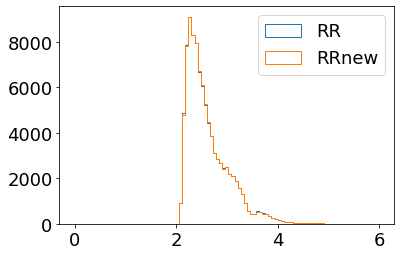

In [8]:
## Test RR
dv_max = 6000 #km/s
bins = np.linspace(0.0,6.0,100)
for c in ['RR','RRnew']:
    zgood = ((data_table['Z_VI']>-1) & 
             (abs(data_table['Z_{}'.format(c)]-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.))
    #w = data_table['ISQSO_VI'] & data_table['ISQSO_{}'.format(c)] & (~zgood) & (data_table['Z_{}'.format(c)]>=2.1)
    #w = (((~data_table['ISQSO_{}'.format(c)]) | (data_table['ISQSO_{}'.format(c)] & (data_table['Z_{}'.format(c)]<2.1)))
    #     & (data_table['ISQSO_VI'] & (data_table['Z_VI']>=2.1)))
    w = ((data_table['ISQSO_{}'.format(c)] & (data_table['Z_{}'.format(c)]>=2.1))
         & (data_table['ISQSO_VI'] & (data_table['Z_VI']>=2.1)))
    wtrue = (data_table['ISQSO_VI'] & (data_table['Z_VI']>=2.1))
    print('{} finds {:2.2%} high-z QSOs ({}/{})'.format(c,w.sum()/wtrue.sum(),w.sum(),wtrue.sum()))
    plt.hist(data_table['Z_VI'][w],bins=bins,histtype='step',label=c)
plt.legend()
plt.show()

### Evaluate performance of classifiers at selecting for reobservation.
xxx

In [9]:
## Define parameters
n_highz_desi = 50
zcut = 2.1
dv_max = 6000. # km/s

# QN/SQ confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


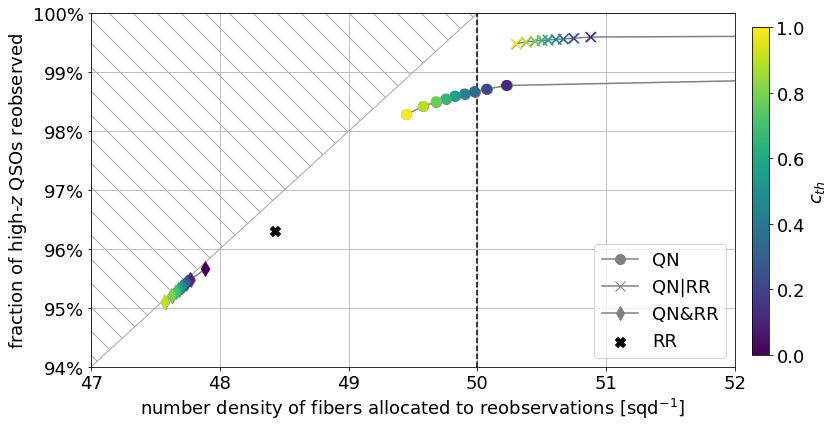

In [10]:
## Standard version of plot
filename = '../plots/classifier_performance_selecting_for_reobservation.pdf'
xmin,xmax = (47,52)
ymin = 0.94

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut) for cth in c_th],
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['QN|RR'] = {'w': [w|(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'color': c_th,
                       'marker': 'x',
                      }

strategies['QN&RR'] = {'w': [w&(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'color': c_th,
                       'marker': 'd',
                      }

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()

In [ ]:
## WIP

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


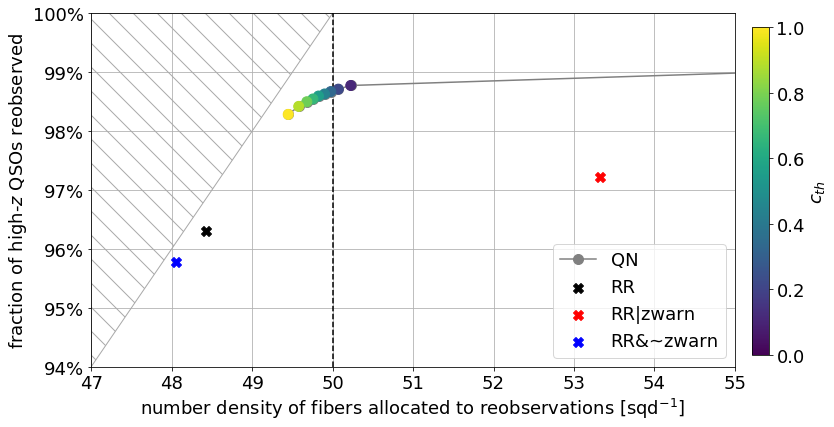

In [11]:
## Standard version of plot but with 3 RR points for including zwarn or not.
filename = '../plots/classifier_performance_selecting_for_reobservation_zwarn.pdf'
xmin,xmax = (47,55)
ymin = 0.94

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut

# RR classifications.
zwarn = data_table['ZWARN_RR']>0
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# RR zwarn classifications.
zwarn = data_table['ZWARN_RR']>0
isqso_rr_zwarn = data_table['ISQSO_RR'] | zwarn
highz_rr_zwarn = (data_table['Z_RR']>=zcut) | zwarn

# RR ~zwarn classifications.
zwarn = data_table['ZWARN_RR']>0
isqso_rr_notzwarn = data_table['ISQSO_RR'] & (~zwarn)
highz_rr_notzwarn = (data_table['Z_RR']>=zcut) & (~zwarn)

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut) for cth in c_th],
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['RR|zwarn'] = {'w': [isqso_rr_zwarn & highz_rr_zwarn],
                    'color': 'r',
                    'marker': 'X',
                   }

strategies['RR&~zwarn'] = {'w': [isqso_rr_notzwarn & highz_rr_notzwarn],
                    'color': 'b',
                    'marker': 'X',
                   }

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


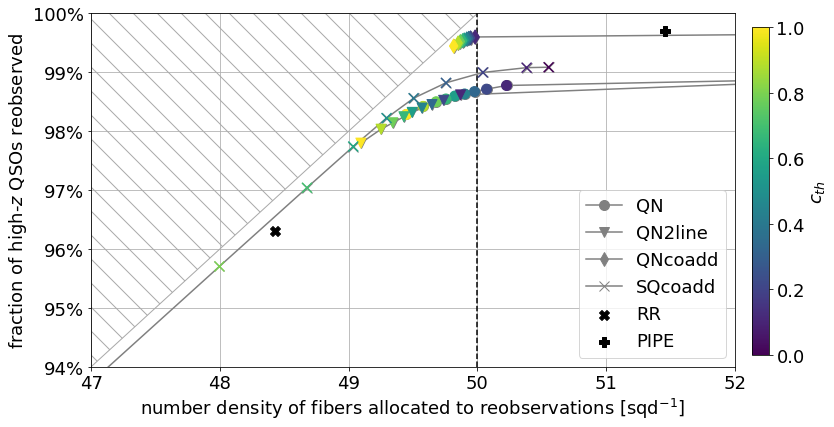

In [12]:
## Extra strategies version of plot
filename = '../plots/classifier_performance_selecting_for_reobservation_extrastrat.pdf'
xmin,xmax = (47,52)
ymin = 0.94

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# PIPE classifications.
isqso_pipe = data_table['ISQSO_PIPE']
highz_pipe = data_table['Z_PIPE']>=zcut

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut
highz_qncoadd = data_table['Z_QNcoadd']>=zcut

# SQ classifications.
highz_sqcoadd = data_table['Z_SQcoadd']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(highz_qn) for cth in c_th],
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['PIPE'] = {'w': [isqso_pipe & highz_pipe],
                    'color': 'k',
                    'marker': 'P',
                   }

strategies['QN2line'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['CMAX2_QN']>cth)&(highz_qn) for cth in c_th],
                    'color': c_th,
                    'marker': 'v',
                   }

strategies['QNcoadd'] = {'w': [(data_table['CMAX_QNcoadd']>cth)&(highz_qncoadd) for cth in c_th],
                    'color': c_th,
                    'marker': 'd',
                   }

strategies['SQcoadd'] = {'w': [(data_table['P_SQcoadd']>cth)&(highz_sqcoadd) for cth in c_th],
                    'color': c_th,
                    'marker': 'x',
                    }

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


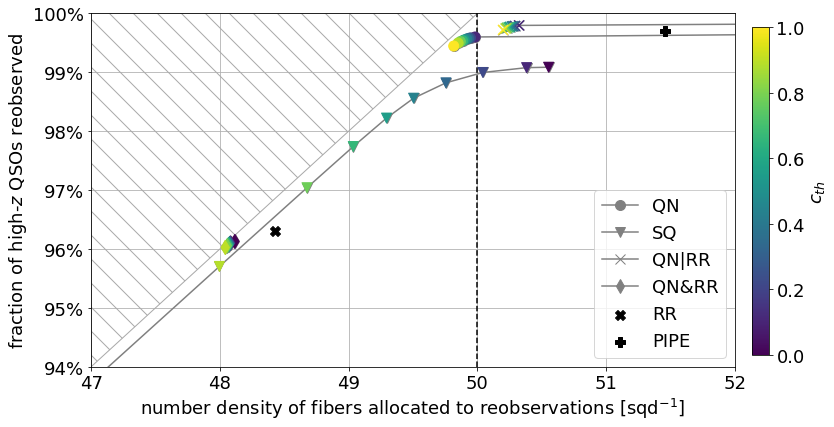

In [15]:
## Coadd only version of plot
filename = '../plots/classifier_performance_selecting_for_reobservation_coadd.pdf'
xmin,xmax = (47,52)
ymin = 0.94

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# PIPE classifications.
isqso_pipe = data_table['ISQSO_PIPE']
highz_pipe = data_table['Z_PIPE']>=zcut

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut
highz_qncoadd = data_table['Z_QNcoadd']>=zcut

# SQ classifications.
highz_sqcoadd = data_table['Z_SQcoadd']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QNcoadd']>cth)&(highz_qncoadd) for cth in c_th],
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['PIPE'] = {'w': [isqso_pipe & highz_pipe],
                    'color': 'k',
                    'marker': 'P',
                   }

strategies['SQ'] = {'w': [(data_table['P_SQcoadd']>cth)&(highz_sqcoadd) for cth in c_th],
                    'color': c_th,
                    'marker': 'v',
                    }

strategies['QN|RR'] = {'w': [w|(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'color': c_th,
                       'marker': 'x',
                      }

strategies['QN&RR'] = {'w': [w&(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'color': c_th,
                       'marker': 'd',
                      }
# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


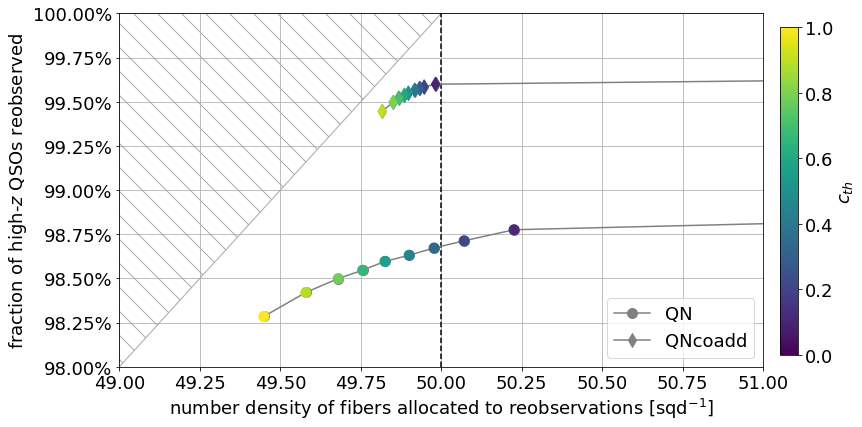

In [17]:
## QN coadd vs single exposure.
filename = '../plots/classifier_performance_selecting_for_reobservation_qnonly.pdf'
xmin,xmax = (49,51)
ymin = 0.98

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut
highz_qncoadd = data_table['Z_QNcoadd']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(highz_qn) for cth in c_th],
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['QNcoadd'] = {'w': [(data_table['CMAX_QNcoadd']>cth)&(highz_qncoadd) for cth in c_th],
                    'color': c_th,
                    'marker': 'd',
                   }

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=2)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


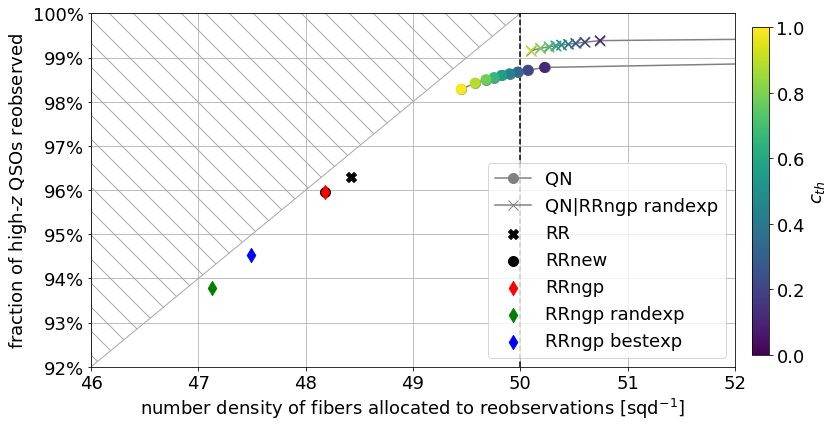

In [19]:
## Compare redrock version of plot
filename = '../plots/classifier_performance_selecting_for_reobservation_rrtest.pdf'
xmin,xmax = (46,52)
ymin = 0.92

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# RRnew classifications.
isqso_rrnew = data_table['ISQSO_RRnew']
highz_rrnew = data_table['Z_RRnew']>=zcut

# RRngp classifications.
isqso_rrngp = data_table['ISQSO_RRngp']
highz_rrngp = data_table['Z_RRngp']>=zcut

# RRngp randexp classifications.
isqso_rrngpr = data_table['ISQSO_RRngp randexp']
highz_rrngpr = data_table['Z_RRngp randexp']>=zcut

# RRngp bestexp classifications.
isqso_rrngpb = data_table['ISQSO_RRngp bestexp']
highz_rrngpb = data_table['Z_RRngp bestexp']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut) for cth in c_th],
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['RRnew'] = {'w': [isqso_rrnew & highz_rrnew],
                    'color': 'k',
                    'marker': 'o',
                   }

strategies['RRngp'] = {'w': [isqso_rrngp & highz_rrngp],
                    'color': 'red',
                    'marker': 'd',
                   }

strategies['RRngp randexp'] = {'w': [isqso_rrngpr & highz_rrngpr],
                    'color': 'green',
                    'marker': 'd',
                   }

strategies['RRngp bestexp'] = {'w': [isqso_rrngpb & highz_rrngpb],
                    'color': 'blue',
                    'marker': 'd',
                   }

strategies['QN|RRngp randexp'] = {'w': [((isqso_rrngpr & highz_rrngpr) | (data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut)) for cth in c_th],
                    'color': c_th,
                    'marker': 'x',
                   }

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()